<h1>Анализ рекламных источников мобильной игры "Космические братья"</h1>

## Материалы

**Описание данных:**

Основной датасет содержит данные о событиях, совершенных в мобильной игре «Космические братья». В ней пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики.

Основная монетизация игры — только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.

В датасете представлены данные по игре пользователей на первом уровне. Завершение первого уровня требует от игрока выполнения одного из двух условий:

* Победа над первым врагом
* Реализация проекта - разработка орбитальной сборки спутников

В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.

Датасет `game_actions.csv`:

- `event_datetime` — время события;
- `event` — одно из трёх событий:
    1. `building` — объект построен,
    2. `finished_stage_1` — первый уровень завершён,
    3. `project` — проект завершён;
- `building_type` — один из трёх типов здания:
    1. `assembly_shop` — сборочный цех,
    2. `spaceport` — космопорт,
    3. `research_center` — исследовательский центр;
- `user_id` — идентификатор пользователя;
- `project_type` — тип реализованного проекта;

Помимо основного датасета есть два датасета с информацией о рекламных активностях. Они также помогут в решении задачи.

Датасет `ad_costs.csv`:

- `day` - день, в который был совершен клик по объявлению
- `source` - источник трафика
- `cost` - стоимость кликов

Датасет `user_source.csv` содержит колонки:

- `user_id` - идентификатор пользователя
- `source` - источников, с которого пришёл пользователь, установивший приложение  


**Цель проекта:** анализ источников перехода в игру для выявления эффективности маркетинговых расходов.


**Задачи:**

* проанализировать поведение игроков,
* из каких источников приходят клиенты и сколько стоит источник,
* когда расходы на привлечение клиента окупаются.


**План выполнения проекта:**

1. Загрузка, первичный осмотр и предобработка данных

    * Проверка корректности наименований колонок
    * Проверка пропущенных значений 
    * Исследование соответствия типов данных
    * Поиск аномальных значений
    * Проверка на дубликаты
    * Добавление расчетов


2. Проведение исследовательского анализа данных

    * Проверка распределения числовых признаков и уникальных значений
    * Количество пользователей за весь период
    * Количество событий за весь период
    * Из каких источников приходит больше всего пользователей
    * CAC для каждого канала
    * ROMI для каждого канала
    


3. Анализ поведения пользоваетелей

    * Составление и анализ профилей пользователей:
    
        - Доля игроков, прошедших первый уровень по каналам;
        - Способ прохождения уровня;
        - Время прохождения;
        - Количество и тип построенных зданий;


4. Проверака статистических гипотез

    * Время завершения уровня различается в зависимости способа прохождения:
        - *через реализацию проекта,*
        - *через победу над первым игроком.*
        
    * Количество построенных зданий различается в зависимости от способа прохождения


5. Вывод

## Загрузка и обзор данных

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st


In [2]:
try:
    ad_costs = pd.read_csv('/datasets/ad_costs.csv')
    game_actions = pd.read_csv('/datasets/game_actions.csv')
    user_source = pd.read_csv('/datasets/user_source.csv')
except:
    ad_costs = pd.read_csv('https://code.s3.yandex.net/datasets/ad_costs.csv')
    game_actions = pd.read_csv('https://code.s3.yandex.net/datasets/game_actions.csv')
    user_source = pd.read_csv('https://code.s3.yandex.net/datasets/user_source.csv')

In [3]:
def intro(df):
    display(df.head(5))
    print()
    df.info()
    print()
    display(df.describe())    
    print('|Количество пропущенных значений|')
    display(df.isna().sum().sort_values(ascending=False))
    print('|Доля пропущенных значений|')
    display(df.isna().mean().sort_values(ascending=False))
    print('|Количество дубликатов|')
    display(df.duplicated().sum())

In [4]:
intro(ad_costs)

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes



,cost
count,28.000000
mean,271.556321
std,286.867650
min,23.314669
25%,66.747365
50%,160.056443
75%,349.034473
max,969.139394


|Количество пропущенных значений|


source    0
day       0
cost      0
dtype: int64

|Доля пропущенных значений|


source    0.0
day       0.0
cost      0.0
dtype: float64

|Количество дубликатов|


0

Названия столбцов корректные, пропусков и дубликатов не обнаружено. Дата имеет формат `object` - необходимо будет поменять ее на `datetime`.

In [5]:
intro(game_actions)

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB



,event_datetime,event,building_type,user_id,project_type
count,135640,135640,127957,135640,1866
unique,128790,3,3,13576,1
top,2020-05-08 21:56:19,building,spaceport,ff841992-d93b-462e-bc6e-18c24a514f36,satellite_orbital_assembly
freq,4,127957,59325,22,1866


|Количество пропущенных значений|


project_type      133774
building_type       7683
event_datetime         0
event                  0
user_id                0
dtype: int64

|Доля пропущенных значений|


project_type      0.986243
building_type     0.056643
event_datetime    0.000000
event             0.000000
user_id           0.000000
dtype: float64

|Количество дубликатов|


1

В таблице `game_actions` в стобцах `building_type` и `project_type` были обнаружены пропущенные значения. Этим пропускам есть объяснение: `building_type` будет пустым, если событие не является постройкой здания, a `project_type`, если событие не является завершением проекта. Таким образом, заполнять пропуски нет необходимости.

Дата имеет формат `object` - необходимо будет поменять ее на `datetime`.

Также в таблице обнаружено одно дублирующееся значение. Нужно будет избавиться от него перед тем как проводить анализ данных.

In [6]:
intro(user_source)

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB



,user_id,source
count,13576,13576
unique,13576,4
top,e8a8e26a-6ef0-4173-ae08-d907d4cacb14,yandex_direct
freq,1,4817


|Количество пропущенных значений|


user_id    0
source     0
dtype: int64

|Доля пропущенных значений|


user_id    0.0
source     0.0
dtype: float64

|Количество дубликатов|


0

Названия столбцов корректные, пропусков и дубликатов не обнаружено. Столбцы имеют нужные форматы.

### Вывод 

В нашем распоряжении имеются три таблицы с данными о событиях, совершенных в мобильной игре «Космические братья». В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.

Согласно документации к данным:

Датасет `game_actions.csv`:

- `event_datetime` — время события;
- `event` — одно из трёх событий:
    1. `building` — объект построен,
    2. `finished_stage_1` — первый уровень завершён,
    3. `project` — проект завершён;
- `building_type` — один из трёх типов здания:
    1. `assembly_shop` — сборочный цех,
    2. `spaceport` — космопорт,
    3. `research_center` — исследовательский центр;
- `user_id` — идентификатор пользователя;
- `project_type` — тип реализованного проекта;

Датасет `ad_costs.csv`:

- `day` - день, в который был совершен клик по объявлению
- `source` - источник трафика
- `cost` - стоимость кликов

Датасет `user_source.csv` содержит колонки:

- `user_id` - идентификатор пользователя
- `source` - источников, с которого пришёл пользователь, установивший приложение  

В ходе первичного обзора данных было выявлено следующее:

* Необходимо поменять тип данных столбцами с датами в датасетах `ad_costs` и `game_actions`
* В таблице `game_actions` в стобцах `building_type` и `project_type` были обнаружены пропущенные значения. Заполнять их не будем, так как отсутствие данных обусловлено отсутствием соответствующих событий.
* Обнаружено дублирующееся значение в датасете `game_actions`. Необходимо будет от него избавиться.

## Предобработка данных

Проверка корректности наименований колонок
Проверка пропущенных значений
Исследование соответствия типов данных
Поиск аномальных значений
Проверка на дубликаты
Добавление расчетов

Для начала приведем тип данных в столбцаъ с датами к необходимому.

In [7]:
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'])
ad_costs['day'] = pd.to_datetime(ad_costs['day'])

Избавимся от дубликата в датасете `game_actions`.

In [8]:
game_actions.duplicated().sum()

1

In [9]:
game_actions = game_actions.drop_duplicates()

In [10]:
game_actions.duplicated().sum()

0

Данные предобработаны. Можно приступать к анлизу данных.

## Исследовательский анализ данных

Проверим, данные за какой период у нас есть.

In [11]:
min_analysis_date = game_actions['event_datetime'].min()
observation_date = game_actions['event_datetime'].max()

print('Начало наблюдения:', min_analysis_date,
      '\nОкончание наблюдения', observation_date)

Начало наблюдения: 2020-05-04 00:00:01 
Окончание наблюдения 2020-06-05 12:32:49


Таким образом у нас есть данные за период с 4 мая по 5 июня.

Посмотрим на распределение количества событий по дням.

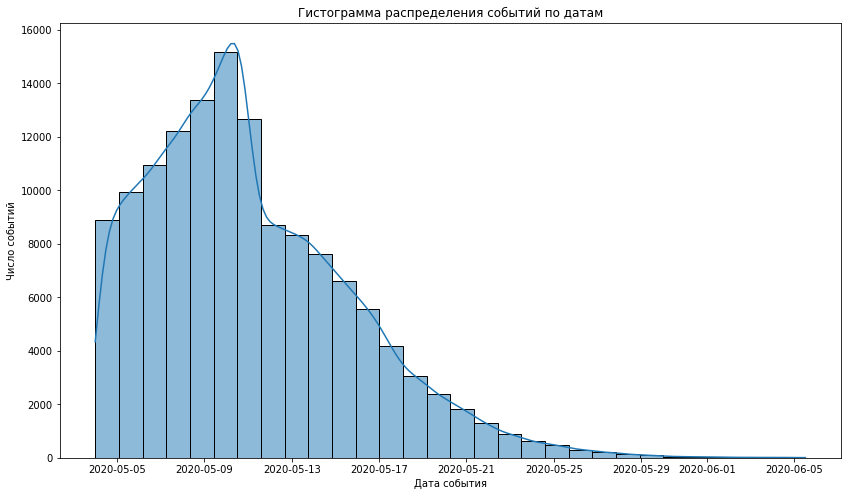

In [12]:
plt.figure(figsize=(14,8))
sns.histplot(data=game_actions['event_datetime'], kde=True, bins=30)
plt.title('Гистограмма распределения событий по датам')
plt.ylabel('Число событий')
plt.xlabel('Дата события')
plt.show()

Можно заметить, что общее количество событий увеличивалось каждый день до 11 мая, а потом резко уменьшилось. Можно предположить, что некоторые пользоваетели завершили уровень и становилось меньше. 

### Количество пользователей и событий за весь период

Проверим количество пользователей и количество событий за весь период.

In [13]:
print(f'Количество пользователей: {game_actions["user_id"].nunique()}')
print(f'Количество событий: {game_actions["event"].count()}')

Количество пользователей: 13576
Количество событий: 135639


### Источники пользователей

Проверим из каких источников приходят пользователи.

In [14]:
user_source.groupby('source')['user_id'].agg('count').reset_index().rename(columns={'user_id': 'count'}).sort_values(by='count', ascending=False)

,source,count
2,yandex_direct,4817
1,instagram_new_adverts,3347
0,facebook_ads,2726
3,youtube_channel_reklama,2686


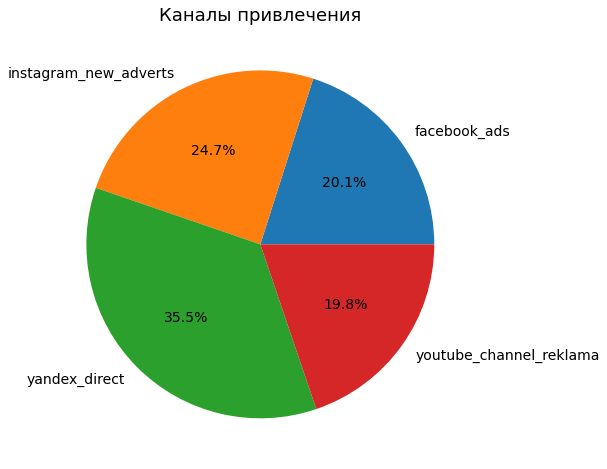

In [15]:
user_source.groupby('source').count().plot(kind='pie', subplots=True, legend= False, autopct='%1.1f%%', figsize=(8, 8),  textprops={'fontsize': 14})
plt.title('Каналы привлечения', fontdict = {'fontsize' : 18})
plt.ylabel('')
plt.show()

Таким образом можно увидеть, что больше всего пользователей (35.5%) приходит из Яндекс Директ. За ним следуют Инстаграм (24.7%), Фейсбук (20.1%) и Ютьюб (19.8%).

### Расчет CAC

Посмотрим стоимость привлечения по каналам и посчитаем CAC.

In [16]:
ad_costs.groupby('source')['cost'].agg('sum').reset_index().sort_values(by='cost', ascending=False)

,source,cost
2,yandex_direct,2233.111449
1,instagram_new_adverts,2161.441691
0,facebook_ads,2140.904643
3,youtube_channel_reklama,1068.119204


In [17]:
ad_sum = ad_costs.groupby('source')['cost'].agg('sum').reset_index()
users_sum = user_source.groupby('source')['user_id'].agg('count').reset_index()
ad_sum['mean_cost'] = (ad_sum['cost'] / users_sum['user_id']).round(2)
ad_sum

,source,cost,mean_cost
0,facebook_ads,2140.904643,0.79
1,instagram_new_adverts,2161.441691,0.65
2,yandex_direct,2233.111449,0.46
3,youtube_channel_reklama,1068.119204,0.40


Общие затраты на привлечение распределены пользователей по каналам распределены соответственно количеству привлеченных пользователей. Но при этом затраты на привлечение одного пользователя выше всего у Фейсбук (0.79), за ним идут Инстаграм (0.65) Яндекс Директ (0.46) и Ютьюб (0.40). 

Таким образом, можно отметить, что при почти одинаковом количестве привлеченных пользователей для Фейсбук и Ютьюб, затраты на привлечение пользователя у последнего в два раза ниже.

### ROMI

Допустим, что привлечённые пользователи должны окупаться за показы рекламы, которые они увидят на первом уровне и исходя из этого предположения высчитаем сколько должен стоить показ каждой рекламы по каналам, чтобы этого добиться.

In [18]:
ad_sum_romi = ad_costs.groupby('source')['cost'].agg('sum').reset_index()
number_events = game_actions.merge(user_source, on='user_id').query('event == "building"').groupby('source')['event'].agg('count').reset_index()
ad_sum_romi['romi'] = (ad_sum_romi['cost'] / number_events['event']).round(2)
ad_sum_romi

,source,cost,romi
0,facebook_ads,2140.904643,0.08
1,instagram_new_adverts,2161.441691,0.07
2,yandex_direct,2233.111449,0.05
3,youtube_channel_reklama,1068.119204,0.04


Таким образом, каждый показ рекламы, должен приносить следующее, чтобы окупаться:
* Facebook - 0.08
* Instagram - 0.07
* Yandex.Direct - 0.05
* Youtube - 0.04

## Анализ поведения пользователей

### Доля игроков, прошедших первый уровень по каналам

Посмотрим количество и долю игроков прошедших первый уровень.

In [19]:
print(f'Количество игроков, прошедших первый уровень: {game_actions["user_id"].nunique()}')
print(f'Доля игроков, прошедших первый уровень: \
{game_actions[game_actions["event"]=="finished_stage_1"]["user_id"].count()/game_actions["user_id"].nunique():.2%}')

Количество игроков, прошедших первый уровень: 13576
Доля игроков, прошедших первый уровень: 42.85%


In [20]:
completed = pd.DataFrame({'is_completed': ['Завершили', 'Не завершили'],
                           'count': [game_actions[game_actions['event'] =='finished_stage_1']['user_id'].nunique(),
                                     game_actions['user_id'].nunique() - game_actions[game_actions['event'] =='finished_stage_1']['user_id'].nunique()]})

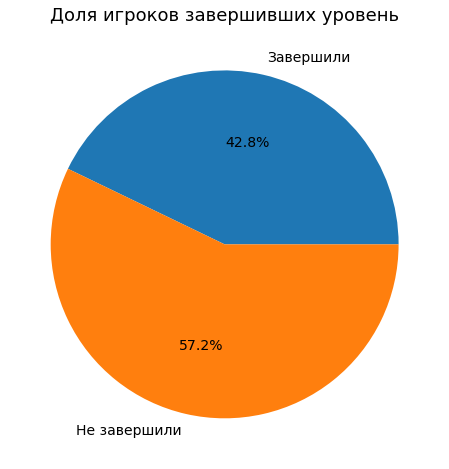

In [21]:
plt.figure(figsize=(8, 8))
plt.title('Доля игроков завершивших уровень', fontdict = {'fontsize' : 18})
plt.pie(completed['count'], labels = ['Завершили', 'Не завершили'],  autopct='%1.1f%%',  textprops={'fontsize': 14})
plt.show() 

Таким образом, мы имеем 42.8% игроков, которые завершили первый уровень и 57.2%, которые не завершили.

Теперь посмотрим долю прошедших первый уровень пользователей от общего числа для каждого канала.

In [22]:
finish_channel = game_actions.merge(user_source, on='user_id')

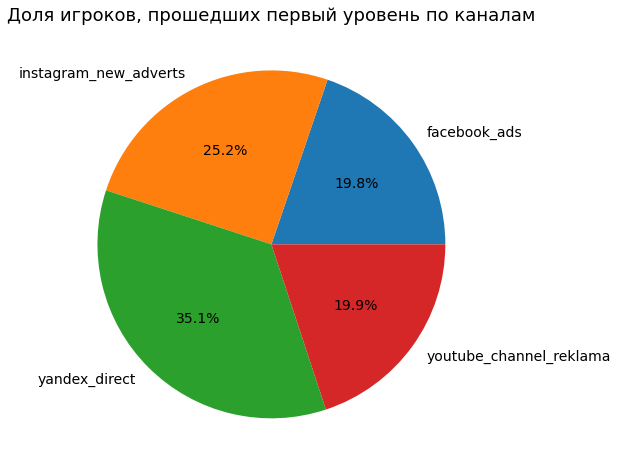

In [23]:
finish_channel[finish_channel["event"]=="finished_stage_1"].groupby('source')['user_id'].agg('nunique').plot(kind='pie', subplots=True, legend= False, autopct='%1.1f%%', figsize=(8, 8),  textprops={'fontsize': 14})
plt.title('Доля игроков, прошедших первый уровень по каналам', fontdict = {'fontsize' : 18})
plt.ylabel('')
plt.show()

Больше всего игроков прошедших первый уровень пришли из Яндекс.Директ (35.1%). За ними следуют игроки пришедшие из Instagram (25.2%). Игроков пришедших из Facebook (19.8%) и Youtube (19.9%) почти одинаковая доля.

### Способ прохождения уровня

Теперь посмотрим как распределены доли игроков по стратегиям прохождения.

In [24]:
print(f'Доля игроков, прошедших первый уровень через реализацию проекта: \
{game_actions[game_actions["event"]=="project"]["user_id"].count()/game_actions[game_actions["event"]=="finished_stage_1"]["user_id"].count():.2%}')

Доля игроков, прошедших первый уровень через реализацию проекта: 32.08%


Создадим список с пользователями, которые закончили игру через проект и построим график.

In [25]:
users = game_actions.query('event == "project"')['user_id'].tolist()

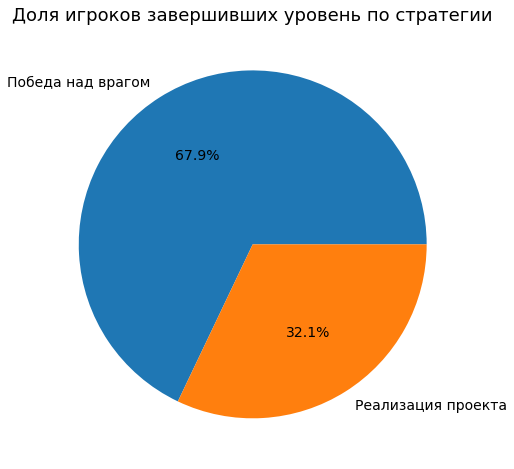

In [26]:
plt.figure(figsize=(8, 8))
plt.title('Доля игроков завершивших уровень по стратегии', fontdict = {'fontsize' : 18})
plt.pie(game_actions.query('user_id not in @users & event!= "building" or event=="project"')['event'].value_counts(), labels = ['Победа над врагом', 'Реализация проекта'],  autopct='%1.1f%%',  textprops={'fontsize': 14})
plt.show() 

Большинство игроков, прошедших первый уровень сделали это через победу над врагом - 67.9%

### Время прохождения

Посмотрим время прохождения уровня игроками.

In [27]:
users_finished_list = game_actions.query('event == "finished_stage_1"')['user_id'].tolist()
users_finished = game_actions.query('user_id in @users_finished_list')
users_finished.head(5)

,event_datetime,event,building_type,user_id,project_type
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN
6,2020-05-04 00:00:36,building,assembly_shop,4fe0f101-694b-4e31-9740-d1d87f7208ea,NaN
8,2020-05-04 00:00:44,building,assembly_shop,65a92713-5969-48b1-8945-bfefa5063887,NaN


In [28]:
finish_time = users_finished.groupby('user_id')['event_datetime'].agg(['min', 'max'])
finish_time['time_to_finish'] = finish_time['max'] - finish_time['min']
finish_time['days_to_finish'] = finish_time['time_to_finish'].astype('timedelta64[D]')
finish_time.head(5)

,min,max,time_to_finish,days_to_finish
user_id,,,,
001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,2020-05-12 07:40:47,6 days 10:38:42,6.0
003ee7e8-6356-4286-a715-62f22a18d2a1,2020-05-05 08:31:04,2020-05-17 21:47:49,12 days 13:16:45,12.0
004074f8-251a-4776-922c-8348dca1a2f6,2020-05-04 01:07:35,2020-05-16 19:57:40,12 days 18:50:05,12.0
00464e5e-28ed-4be6-bf44-517ef7b3937b,2020-05-04 08:35:29,2020-05-15 16:02:01,11 days 07:26:32,11.0
0056c007-c082-43cc-bdef-afc49bca4cb9,2020-05-10 11:49:47,2020-05-16 13:48:39,6 days 01:58:52,6.0


In [29]:
print(f'Самое быстрое прохождение: {finish_time["time_to_finish"].min()}')
print(f'Самое долгое прохождение: {finish_time["time_to_finish"].max()}')
print(f'Среднее время прохождения: {finish_time["days_to_finish"].mean().round()} дней')

Самое быстрое прохождение: 0 days 09:39:01
Самое долгое прохождение: 30 days 21:58:53
Среднее время прохождения: 11.0 дней


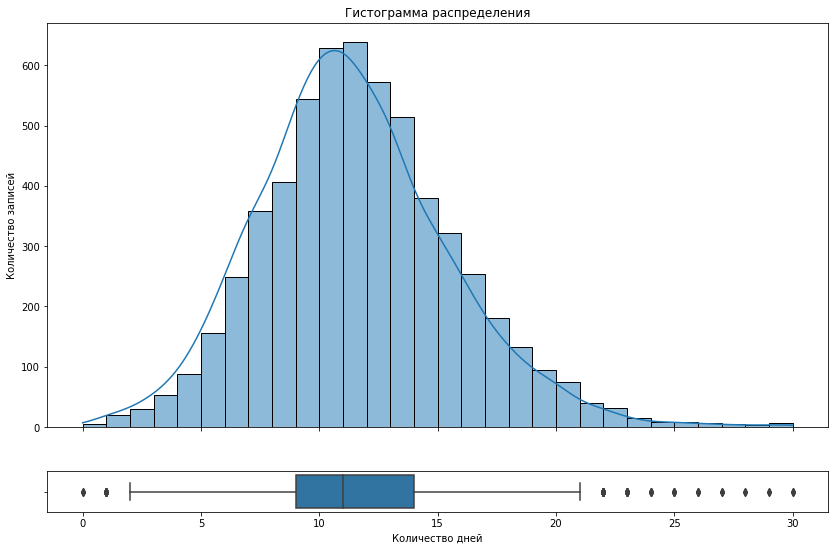

In [30]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(14, 9), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[10,1]))
hist = sns.histplot(data=finish_time['days_to_finish'], kde=True, ax=axs_hist, bins=30)
box = sns.boxplot(data=finish_time, x='days_to_finish', orient='h', ax=axs_box)
hist.set(title='Гистограмма распределения',
         ylabel='Количество записей')
box.set(xlabel='Количество дней');

Таким образом, можно отметить, что самое быстрое прохождение первого уровня игры было 09:39:01.

Самое долгое - 30 дней и 21:58:53.

В среднем игроки проходят первый уровень за 11 дней. 

Исходя из диаграммы размаха можно считать, что все что меньше 9 дней - это быстрое прохождение уровня, а все что больше 14 дней - медленное.

### Количество и тип построенных зданий

Посмотрим на количество и тип построенных игроками зданий и построим визуализации.

In [31]:
game_actions['building_type'].value_counts().to_frame()

,building_type
spaceport,59325
assembly_shop,54494
research_center,14137


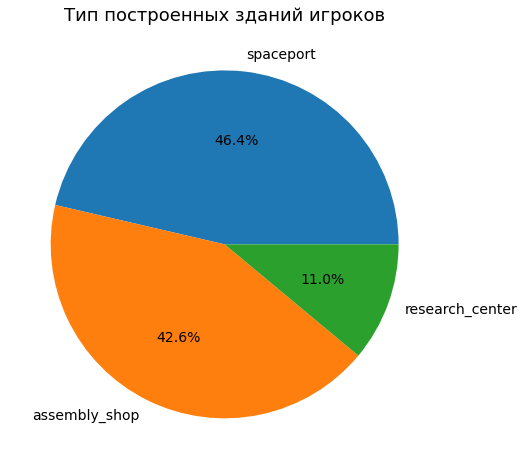

In [32]:
game_actions['building_type'].value_counts().plot(kind='pie', subplots=True, legend= False, autopct='%1.1f%%', figsize=(8, 8),  textprops={'fontsize': 14})
plt.title('Тип построенных зданий игроков', fontdict = {'fontsize' : 18})
plt.ylabel('')
plt.show()

В целом по всем игрокам больше всего строят `spaceport` - 46.4%, за ним идет `assembly_shop` - 42.6% и замыкает тройку `research_center` - 11%.

Посмотрим на количество и тип построенных игроками зданий среди игроков завершивших уровень через реализацию проекта.

In [33]:
print('Среднее количество построенных зданий на пользователя:', (game_actions.query('event== "building" & user_id in @users')['event'].count()/game_actions.query('event== "building" & user_id in @users')['user_id'].nunique()).round())

Среднее количество построенных зданий на пользователя: 13.0


In [34]:
game_actions.query('event== "building" & user_id in @users')['building_type'].value_counts().to_frame()

,building_type
spaceport,10788
assembly_shop,9116
research_center,3697


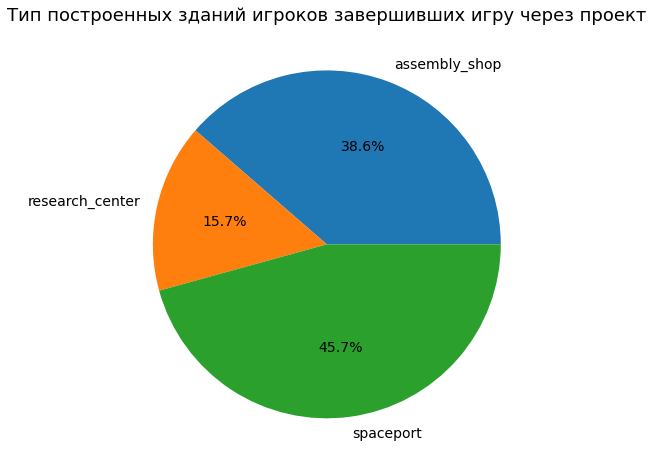

In [35]:
game_actions.query('event== "building" & user_id in @users').groupby('building_type')['user_id'].count().plot(kind='pie', subplots=True, legend= False, autopct='%1.1f%%', figsize=(8, 8),  textprops={'fontsize': 14})
plt.title('Тип построенных зданий игроков завершивших игру через проект', fontdict = {'fontsize' : 18})
plt.ylabel('')
plt.show()

Среднее количество построенных зданий среди пользователей завершивших первый уровень через реализацию проекта - 13.

Среди игроков завершивших первый уровень через реализацию проекта больше всего строят `spaceport` - 45.7%, за ним идет `assembly_shop` - 38.6% и замыкает тройку `research_center` - 15.7%.

Посмотрим на количество и тип построенных игроками зданий среди игроков завершивших уровень через победу над врагом.

In [36]:
print('Среднее количество построенных зданий на пользователя:', (game_actions.query('event== "building" & user_id not in @users')['event'].count()/game_actions.query('event== "building" & user_id not in @users')['user_id'].nunique()).round())

Среднее количество построенных зданий на пользователя: 9.0


In [37]:
game_actions.query('event== "building" & user_id not in @users')['building_type'].value_counts().to_frame()

,building_type
spaceport,48537
assembly_shop,45378
research_center,10440


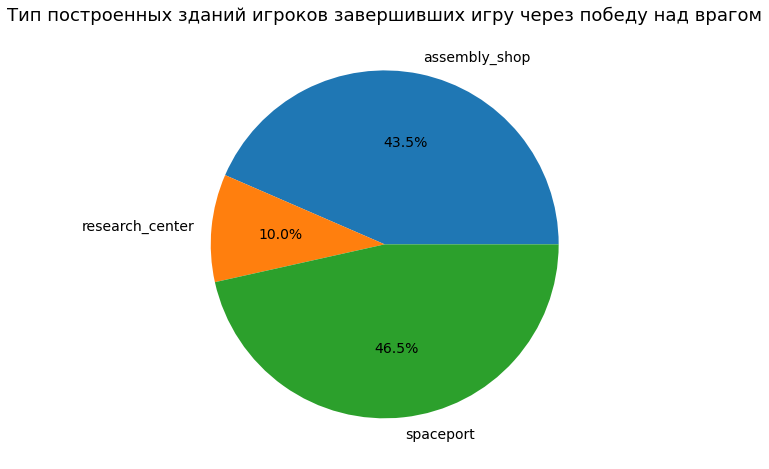

In [38]:
game_actions.query('event== "building" & user_id  not in @users').groupby('building_type')['user_id'].count().plot(kind='pie', subplots=True, legend= False, autopct='%1.1f%%', figsize=(8, 8),  textprops={'fontsize': 14})
plt.title('Тип построенных зданий игроков завершивших игру через победу над врагом', fontdict = {'fontsize' : 18})
plt.ylabel('')
plt.show()

In [39]:
(game_actions.query('event== "building" & user_id not in @users')['event'].count()/game_actions.query('event== "building" & user_id not in @users')['user_id'].nunique()).round()

9.0

Среднее количество построенных зданий среди пользователей завершивших первый уровень через победу над врагом - 9.

Среди игроков завершивших первый уровень через победу над врагом больше всего строят `spaceport` - 46.5%, за ним идет `assembly_shop` - 43.5% и замыкает тройку `research_center` - 10%.

Таким образом можно сказать, что распределение построенных зданий в целом не отличается среди пользователей. При этом пользователи прошедшие первый уровень через реализацию проекта строят в среднем больше зданий 13 против 9 для тех кто прошел победив врага.

## Проверка статистических гипотез

### Гипотеза 1

Проверим следующую гипотезу: 

H0: Время завершения уровня не различается в зависимости способа прохождения  
H1: Время завершения уровня различается в зависимости способа прохождения

Проверим гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам . Порог `alpha` зададим на уровне 5% 

In [40]:
project = game_actions.query('event== "finished_stage_1" & user_id in @users')['user_id'].to_list()

In [41]:
fight = game_actions.query('event== "finished_stage_1" & user_id not in @users')['user_id'].to_list()

In [42]:
project_users_time = game_actions.query('user_id in @project').groupby('user_id')['event_datetime'].agg(['min', 'max'])
project_users_time['time_to_finish'] = (project_users_time['max'] - project_users_time['min']).astype('timedelta64[s]')
project_users_time.head(5)

,min,max,time_to_finish
user_id,,,
006380d6-67a6-45de-ab1e-6eb54ad8dbe8,2020-05-04 16:43:39,2020-05-16 11:22:33,1017534.0
00be7371-fa79-4fbd-b8e7-8ba32e3f8f82,2020-05-08 21:57:44,2020-05-24 19:05:12,1372048.0
00c2b9f2-2615-439c-aed0-6974e4c6c1c1,2020-05-07 10:26:09,2020-05-27 11:38:47,1732358.0
00de2809-403e-4476-a2f7-ca1b11700190,2020-05-04 07:48:50,2020-05-18 09:34:10,1215920.0
00e83261-5fd4-4939-9616-802b5a0202c6,2020-05-05 15:49:57,2020-05-20 09:35:04,1273507.0


In [43]:
fight_users_time = game_actions.query('user_id in @fight').groupby('user_id')['event_datetime'].agg(['min', 'max'])
fight_users_time['time_to_finish'] = (fight_users_time['max'] - fight_users_time['min']).astype('timedelta64[s]')
fight_users_time.head(5)

,min,max,time_to_finish
user_id,,,
001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,2020-05-12 07:40:47,556722.0
003ee7e8-6356-4286-a715-62f22a18d2a1,2020-05-05 08:31:04,2020-05-17 21:47:49,1084605.0
004074f8-251a-4776-922c-8348dca1a2f6,2020-05-04 01:07:35,2020-05-16 19:57:40,1104605.0
00464e5e-28ed-4be6-bf44-517ef7b3937b,2020-05-04 08:35:29,2020-05-15 16:02:01,977192.0
0056c007-c082-43cc-bdef-afc49bca4cb9,2020-05-10 11:49:47,2020-05-16 13:48:39,525532.0


In [44]:
alpha = .05 

results = st.ttest_ind(fight_users_time['time_to_finish'], project_users_time['time_to_finish'], equal_var = False)

print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу. Среднее время прохождения уровня в зависимости от способа прохождения различаются.')
else:
    print('Не получилось отвергнуть нулевую гипотезу. Среднее время прохождения уровня в зависимости от способа прохождения не различаются')

p-value: 5.708058235069063e-107
Отвергаем нулевую гипотезу. Среднее время прохождения уровня в зависимости от способа прохождения различаются.


### Гипотеза 2

Проверим следующую гипотезу: 

H0: Количество построенных зданий не различается в зависимости способа прохождения  
H1: Количество построенных зданий различается в зависимости способа прохождения

Для проверки гипотез будем использовать непараметрический тест Уилкоксона-Манна-Уитни. Порог `alpha` зададим на уровне 5% 

In [45]:
fight_users_buildings = game_actions.query('user_id in @fight').groupby('user_id')['building_type'].count()
project_users_buildings = game_actions.query('user_id in @project').groupby('user_id')['building_type'].count()

In [46]:
alpha = .05
pvalue = st.mannwhitneyu(fight_users_buildings, project_users_buildings)[1]

print(f'p-value: {pvalue}')

if pvalue < alpha: 
    print('Отвергаем нулевую гипотезу. Cреднее количество построенных зданий различается в зависимости способа прохождения.')
else: 
    print('Не получилось отвергнуть нулевую гипотезу. Cреднее количество построенных зданий не различается в зависимости способа прохождения')

p-value: 5.211926275022306e-305
Отвергаем нулевую гипотезу. Cреднее количество построенных зданий различается в зависимости способа прохождения.


## Вывод

В ходе анализа рекламных источников для игры «Космические братья» было выявлено следующее:

* Количество уникальных пользователей - 13576
* Количество событий - 135639
* Основные источники пользователей:

    - Яндекс.Директ - 35.5%
    - Instagram - 24.7%
    - Facebook - 20.1%
    - Youtube - 19.8%
    
* CAC по источникам:

    - Facebook - 0.79 
    - Instagram - 0.65
    - Яндекс.Директ - 0.46
    - Youtube - 0.40

* каждый показ рекламы, должен приносить следующее, чтобы окупаться:

    - Facebook - 0.08
    - Instagram - 0.07
    - Yandex.Direct - 0.05
    - Youtube - 0.04

* Меньше половины игроков (42.8%) завершили первый уровень
* Большая часть прошедших первый уровень сделали это через победу над врагом - 67.9%
* Больше всего игроков прошедших первый уровень пришли из Яндекс.Директ - 35.1%
* Самое быстрое прохождение первого уровня игры было 09:39:01. Самое долгое - 30 дней и 21:58:53. В среднем игроки проходят первый уровень за 11 дней.
* Игроки, прошедшие уровень через реализацию проекта строят больше зданий - 13. Те, кто проходит через победу над врагом - 9.
* Больше всего игроки строят `spaceport` - 46.4%, за ним идет `assembly_shop` - 42.6% и замыкает тройку `research_center` - 11%.

Также были проверены следующие гипотезы:

1. Время завершения уровня зависит от способа прохождения. Отвергли нулевую гипотезу. Среднее время прохождения уровня в зависимости от способа прохождения различаются.

2. Количество построенных зданий зависит от способа прохождения. Отвергли нулевую гипотезу. Cреднее количество построенных зданий различается в зависимости способа прохождения.


Рекомендации:

* Следует привлекать новых пользователей через самые выгодные каналы - Youtube и Яндекс.Директ. Точка окупаемости у них самая низкая. 
* Игроки чаще завершают уровень через победу над другим игроком, чем через реализацию проекта. При этом игроки, завершающие проект, строят в среднем больше зданий. При предполагаемой модели монетизации через показ рекламы на экране с выбором типа объекта для постройки, следует подумать о том, как заставить больше игроков завершать игру через проект. Например, можно давать  бонусы на следующем уровне при прохождении игры таким способом или давать очки рейтинга за количество построенных зданий.